# Imports 

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
%matplotlib inline

###### Shortcuts
1. Command --esc
2. Editor  --Enter
3. Markdown -- m
4. Fonte Size --1,2,3,4,5,6
5. Run Cell and insert belwo -- shift+enter
6. Run Cell -- Ctrl + enter

In [3]:
tf.__version__

'0.11.0'

# Load Data

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("data/MINST/",one_hot=True)

Extracting data/MINST/train-images-idx3-ubyte.gz
Extracting data/MINST/train-labels-idx1-ubyte.gz
Extracting data/MINST/t10k-images-idx3-ubyte.gz
Extracting data/MINST/t10k-labels-idx1-ubyte.gz


In [5]:
print("Size of:")
print("- Training-set:\t\t{}". format(len(data.train.labels)))
print("- Test-set:\t\t{}". format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


# One-hot Encoding 

In [6]:
data.test.labels[0:5,:]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])

In [7]:
data.test.cls = np.array([label.argmax() for label in data.test.labels])

In [8]:
data.test.cls[0:5]

array([7, 2, 1, 0, 4])

# Data dimensions 

In [9]:
# MINST images are 28 pixels in each dimension
img_size = 28

#Images are stored in one-dimensional arrays of this length
img_size_flat = img_size * img_size

#Tuple with height and width of images used to reshape array
img_shape = (img_size, img_size)

#NUmber of classes, one class for each of 10 digits
num_classes=10

# Helper-function for plotting images 

In [10]:
def plot_images(images,cls_true,cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    #create figure with 3*3 subplots
    fig,axes = plt.subplots(3,3)
    fig.subplots_adjust(hspace=0.3,wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        #plot image
        ax.imshow(images[i].reshape(img_shape),cmap='binary')
        
        #show true and predicted classes.
        if cls_pred is None:
            xlabel = "True:{0}".format(cls_true[i])
        else:
            xlabel = "True:{0}, Pred: {1}".format(cls_true[i],cls_pred[i])
        ax.set_xlabel(xlabel)
        
        #remove ticks from the plot
        ax.set_xticks([])
        ax.set_yticks([])
    #plt.show()

###  Plot a few images to see if data is correct

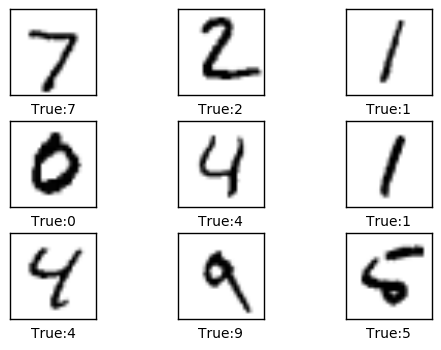

In [44]:
images = data.test.images[0:9]

cls_true = data.test.cls[0:9]

plot_images(images=images,cls_true=cls_true)

In [45]:
x = tf.placeholder(tf.float32,[None,img_size_flat])
#input image

In [46]:
y_true = tf.placeholder(tf.float32,[None,num_classes])
#true labels associated with the images

In [47]:
y_true_cls= tf.placeholder(tf.int64,[None])
#the true class of each images
# placeholder variable is a one-dimensional vector of arbitrary length

### Variables to be optimized 

In [48]:
#weights is a 2-dimensional tensor with img_size_flat rows and num_classes columns
weights = tf.Variable(tf.zeros([img_size_flat,num_classes]))

#bias is a 1-dimensional tensor of length num_class
biases = tf.Variable(tf.zeros([num_classes]))

In [49]:
logits = tf.matmul(x,weights) + biases

###  use softmax to  normalize logits

In [50]:
y_pred = tf.nn.softmax(logits)

###  The largest element in softmax is the class type we find

In [51]:
y_pred_cls = tf.argmax(y_pred,dimension=1)

### Optimize the cost-function----minimize the cross entropy

In [52]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=y_true)

#cost function is the average of cross entropy
cost = tf.reduce_mean(cross_entropy) 

### Use gradient descent to minimize the cost

In [53]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

### performance measures---boolean--average

In [56]:
correct_prediction = tf.equal(y_pred_cls,y_true_cls)

accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

# Tensorflow Run
### create tensorflow session-initialize variables

In [57]:
session = tf.Session()
session.run(tf.initialize_all_variables())

### Helper function to perform optimization iterations
### Use stochastic gradient descent 

In [58]:
# only use small batch of images in each iteration of the optimizer
batch_size = 100

In [59]:
def optimize(num_iterations):
    for i in range(num_iterations):
        #get a batch of training examples
        #x_batch now holds a batch of images and
        #y_true_batch are the true labels for those images
        x_batch, y_true_batch = data.train.next_batch(batch_size)
        
        #put the batch into a dict wiht the proper names
        #for placeholder variables in the tensorflow graph
        #note that the placeholder for y_true_cls is not set
        #because it is not used during training
        feed_dict_train = {x:x_batch,y_true:y_true_batch}
        
        #run the optimizer using this batch of training data
        #Tensorflow assigns the variables in feed_dict_train
        #to the placeeholder variables and then runs the optimizer
        session.run(optimizer,feed_dict=feed_dict_train)

### Helper functions to show performance

In [60]:
feed_dict_test = {x:data.test.images,
                  y_true:data.test.labels,
                  y_true_cls:data.test.cls}
#test-set data 

In [61]:
def print_accuracy():
    #use tensorflow to compute the accuracy
    acc = session.run(accuracy,feed_dict=feed_dict_test)
    
    #print the accuracy
    print("Accuracy on test-set:{0:.1%}".format(acc))
    

In [82]:
def print_confusion_matrix():
    #get the true classifications for the test-set
    cls_true = data.test.cls
    
    #get the predicted classification for the test-set
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)
    
    #get the confusion matrix using sklearn
    cm = confusion_matrix(y_true=cls_true,y_pred=cls_pred)
    
    #print&plot
    print(cm)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.Blues)
    
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks,range(num_classes))
    plt.yticks(tick_marks,range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    

In [63]:
#plot examples of images from the test-set that have been mis-classified
def plot_example_errors():
    #use tensorflow to get a list of boolean values
    #whether each test-image has been correctly classified
    #and a list for the predicted class of each image
    correct, cls_pred = session.run([correct_prediction,y_pred_cls],feed_dict=feed_dict_test)
    
    #negate the boolean array
    incorrect = (correct == False)
    
    #get the images from the test-set that have been incorrectly classified
    images = data.test.images[incorrect]
    
    #get the predicted classes for those images
    cls_pred = cls_pred[incorrect]
    
    #get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    #plot the first 9 images
    plot_images(images=images[0:9],cls_true=cls_true[0:9],cls_pred=cls_pred[0:9])

### Helper function to plot the model weights

In [64]:
def plot_weights():
    #get the value for the weights from the tensorflow variable
    w = session.run(weights)
    
    #get the lowest&highest values for the weigths
    #this is used to correct the colur intensity across the images so they can be compared wiht each other
    w_min = np.min(w)
    w_max = np.max(w)
    
    #create figure with 3*4 sub-plots the last 2 are unused
    fig,axes = plt.subplots(3,4)
    fig.subplots_adjust(hspace=0.3,wspace=0.3)
    
    for i,ax in enumerate(axes.flat):
        #only use the weights for the first 10 sub-plots
        if i<10:
            #get the weights for the i'th digit and reshape it
            #note w.shape==(img_size_flat,10)
            image = w[:,i].reshape(img_shape)
            
            #set the label for the sub-plot
            ax.set_xlabel("weights:{0}".format(i))
            
            #plot the image
            ax.imshow(image,vmin=w_min,vmax=w_max,cmap='seismic')
            
            #remove ticks from each sub-plot
            ax.set_xticks([])
            ax.set_yticks([])
    

## Performance before any optimization

In [65]:
print_accuracy()

Accuracy on test-set:9.8%


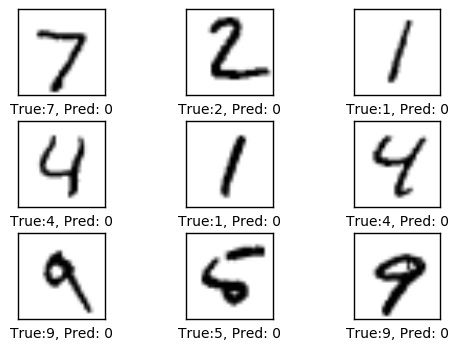

In [66]:
plot_example_errors()
#the prediction are zeros because we set the initial value into zeros 

### Performance after 1 optimization iteration

In [68]:
optimize(num_iterations=1)

In [69]:
print_accuracy()

Accuracy on test-set:40.7%


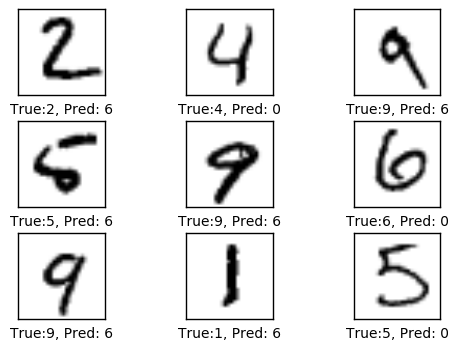

In [70]:
plot_example_errors()

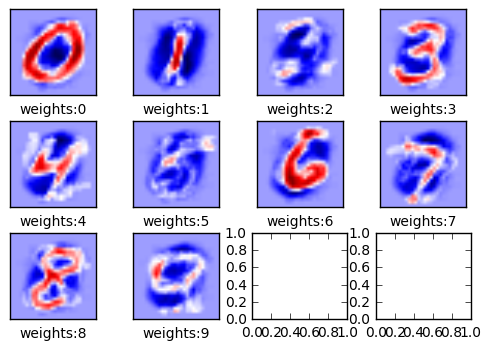

In [71]:
#positive weights are red,negative weights are blue
plot_weights()

## Performance after  10 optimization iterations

In [72]:
optimize(num_iterations=9)

In [73]:
print_accuracy()

Accuracy on test-set:78.2%


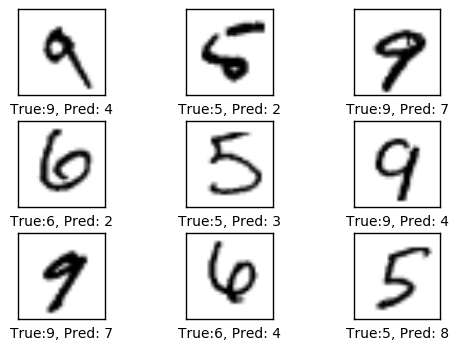

In [74]:
plot_example_errors()

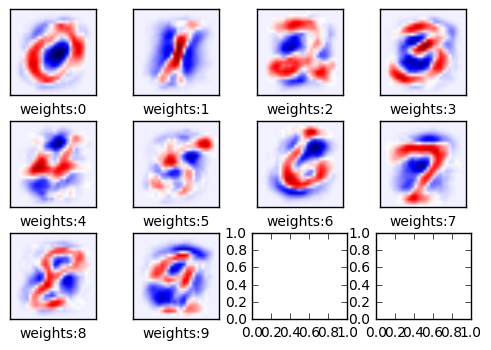

In [75]:
plot_weights()

## Performance after 1000 optimization iterations

In [76]:
optimize(num_iterations=990)

In [77]:
print_accuracy()

Accuracy on test-set:91.7%


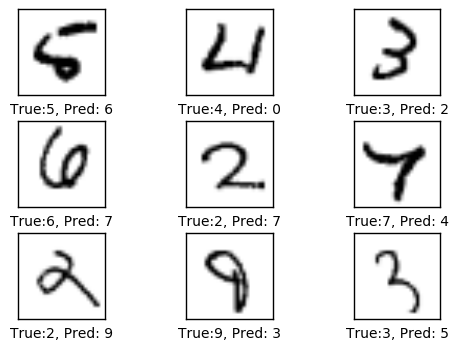

In [79]:
plot_example_errors()

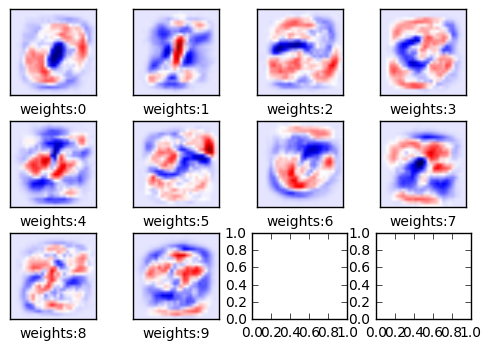

In [80]:
plot_weights()

[[ 968    0    2    3    0    2    3    1    1    0]
 [   0 1110    2    2    0    1    4    2   14    0]
 [  11    7  934   13    9    1   10   11   28    8]
 [   3    0   24  926    0   21    1   13   13    9]
 [   4    2    9    1  892    0    7    3    6   58]
 [  13    2    6   58    8  748   12    9   26   10]
 [  20    3    7    2   11   16  892    4    3    0]
 [   3    7   23    8    6    0    0  944    0   37]
 [  12    8    9   30    9   30   10   15  833   18]
 [  12    6    2   11   20    5    0   25    6  922]]


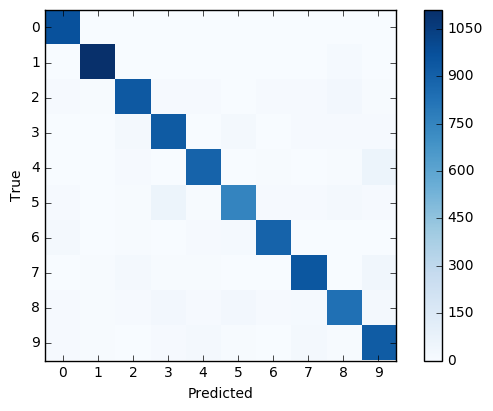

In [83]:
print_confusion_matrix()